In [2]:
'''
Author: Sriram Yarlagadda
Date Created: 8/26/2016
Note: Please use Python 2.7
'''
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir('C:\Users\syarlag1\Desktop\Loyola-SAH-Analysis') #Set location of home dir here.
#os.chdir('/Users/Sriram/Desktop/DePaul/Loyola-SAH-Analysis')#location in Mac

### Reading Data

Only the variables needed are extracted. See the variable "varLst".

In [3]:
os.chdir('./data')
dataFiles = os.listdir('.')
varLst = ['KEY','LOS','DIED','AGE','SAH','ASA','PT_INT_SAH','PT_INT_SAH_ASA','SCORE']#Names of the variables we need
fullDataDict = {}
for fileName in dataFiles:
    dataStr = fileName[:2] + 'Data'; print dataStr #print to confirm that the data is created
    fullDataDict[dataStr] = pd.DataFrame()
    fullDataDict[dataStr] = pd.read_stata(fileName, columns=varLst)
    fullDataDict[dataStr]['KEY'] = fullDataDict[dataStr]['KEY'].astype(str)#Setting the KEY variable as an object   
    #fullDataDict[dataStr].index = fullDataDict[dataStr]['KEY']; del fullDataDict[dataStr]['KEY'] #Setting 'KEY' as index

CAData
FLData
IAData
NYData
WAData


In [4]:
for key in fullDataDict.keys(): #creating a new state identifier column
    fullDataDict[key]['State'] = pd.Series([str(key)[:2]]*fullDataDict[key].shape[0])
allStateData = pd.concat(fullDataDict.values()) #combing into a single dataframe
allStateData.index = range(allStateData.shape[0])

### Data Preprocessing

In [5]:
allStateData.describe()

,LOS,DIED,AGE,SAH,ASA,PT_INT_SAH,PT_INT_SAH_ASA,SCORE
count,38307.000000,38304.000000,38231.000000,38310.0,38310.000000,38310.0,38310.000000,38310.000000
mean,12.153001,0.204626,58.659569,1.0,0.033908,1.0,0.033908,5.732522
std,37.072215,0.406335,16.465707,0.0,0.180971,0.0,0.180971,10.280618
min,-6666.000000,-9.000000,0.000000,1.0,0.000000,1.0,0.000000,0.298197
25%,3.000000,0.000000,48.000000,1.0,0.000000,1.0,0.000000,0.932394
50%,9.000000,0.000000,58.000000,1.0,0.000000,1.0,0.000000,0.932394
75%,17.000000,0.000000,71.000000,1.0,0.000000,1.0,0.000000,6.958751
max,362.000000,1.000000,111.000000,1.0,1.000000,1.0,1.000000,106.059479


As we can see, there are some abberations. For example, the min of LOS is -6666, which is not possible. Hence we scan for other such outliers and remove the cases that correspond to them.

In [6]:
np.sum(np.array(allStateData < 0), 0)

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

As we can see from the above output, only two features -- LOS and DIED -- have negative values. We look at the cases that correspond to these:

In [7]:
allStateData[allStateData['DIED'] < 0]

,KEY,LOS,DIED,AGE,SAH,ASA,PT_INT_SAH,PT_INT_SAH_ASA,SCORE,State
35184,6.20061320052e+12,1.0,-9.0,46.0,1.0,0.0,1.0,0.0,6.958751,CA


In [8]:
allStateData[allStateData['LOS'] < 0]

,KEY,LOS,DIED,AGE,SAH,ASA,PT_INT_SAH,PT_INT_SAH_ASA,SCORE,State
24598,6.20061082797e+12,-6666.0,0.0,67.0,1.0,0.0,1.0,0.0,5.473947,CA


In [9]:
np.sum(np.array(pd.isnull(allStateData)),0)

array([ 0,  3,  6, 79,  0,  0,  0,  0,  0,  0])

There are **89** missing values in our data.

We remove all cases which have such outliers:

In [10]:
for feature in allStateData.columns: 
    allStateData = allStateData[allStateData[feature] >= 0] #removing all the cases that are less than 0 (only 2 in our case)

In [11]:
os.chdir('./..') 
allStateData.to_csv('./allStateData.csv') #saving entire file for easy future access

### Data Exploration

In this section we first look at how the cases are distributed by STATE and ASA status and then we visualize the relation between the SCORE, DIED, and LOS variables and the ASA status (0 or 1)

In [12]:
allStateData = pd.read_csv('./allStateData.csv')#ignore this if running script from top

#### First we look at the distribution of the case counts by State and ASA status

Taking a look at the number of cases by state:

In [13]:
allStateData.State.value_counts()

CA    18357
FL     8602
NY     8318
WA     2006
IA      937
Name: State, dtype: int64

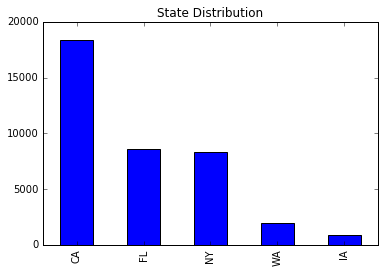

In [14]:
allStateData.State.value_counts().plot('bar')
plt.title('State Distribution')

As seen above, California has the most number of cases, more than the next two (FL and NY) combined.


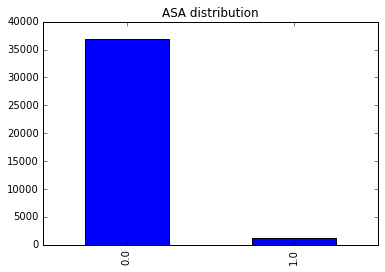

In [15]:
allStateData.ASA.value_counts().plot('bar')
plt.title('ASA distribution')

The above barplot shows us that there are **far fewer** cases of ASA than without ASA

#### We now look at the distribution of the SCORE variable

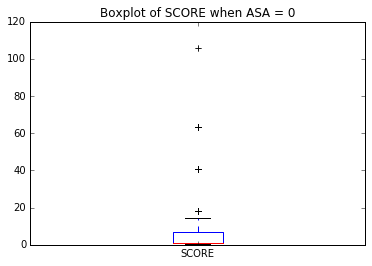

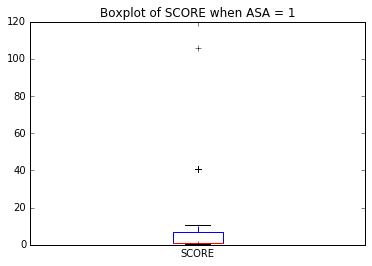

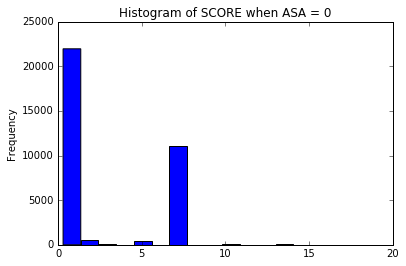

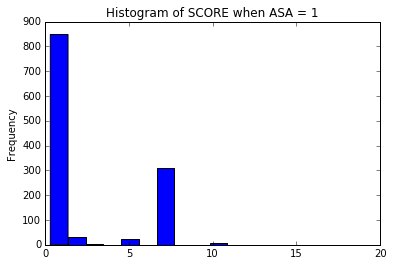

In [16]:
###ASA = 0
allStateData[allStateData.ASA == 0.].SCORE.plot('box')
plt.title('Boxplot of SCORE when ASA = 0'); plt.show()
###ASA == 1
allStateData[allStateData.ASA == 1.].SCORE.plot('box')
plt.title('Boxplot of SCORE when ASA = 1'); plt.show()
###ASA = 0
allStateData[allStateData.ASA == 0.].SCORE.plot('hist', xlim=(0,20), bins = 100) #zooming in to ignore outliers
plt.title('Histogram of SCORE when ASA = 0'); plt.show()
###ASA = 1
allStateData[allStateData.ASA == 1.].SCORE.plot('hist', xlim=(0,20), bins = 100) #zooming in to ignore outliers
plt.title('Histogram of SCORE when ASA = 1'); plt.show()

From above we can see that both ASA = 1 and ASA = 0 both have a similar distribution for the SCORE variable. However, it is important to notice that these distributions are **NOT** normal. T-tests may **not** be appropriate when the distributions are not normal.

Since there seem to be a lot of discrete values, we also create a cross tabulation (contingency table) of the data with proportions:

In [17]:
pd.crosstab(allStateData.SCORE, allStateData.ASA).apply(lambda x: x/x.sum(), 0).sort_index()

ASA,0.0,1.0
SCORE,,
0.298197,0.015573,0.012327
0.463013,0.000217,0.001541
0.774142,0.000081,0.000000
0.932394,0.578679,0.639445
1.447735,0.008044,0.020801
1.558931,0.000027,0.000000
1.750672,0.000108,0.000000
2.225541,0.006392,0.003082
2.420563,0.001165,0.002311


From the table the main difference between ASA=0 and ASA=1 Scores is at **6.958 and 0.9324**

#### Next we look at the distribution of LOS variable

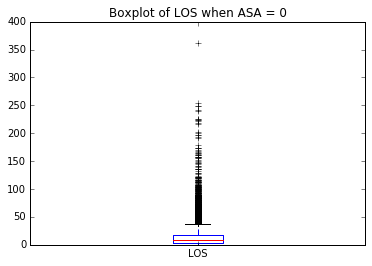

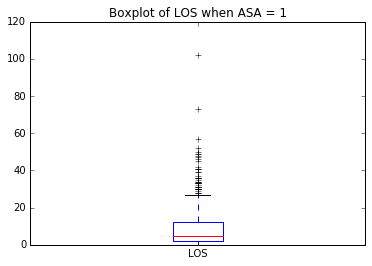

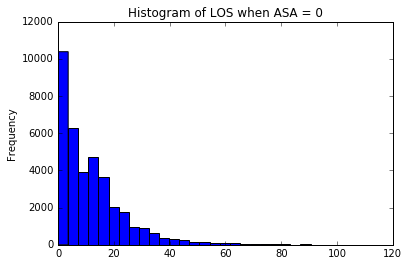

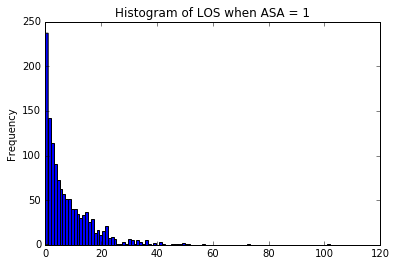

In [18]:
###ASA = 0
allStateData[allStateData.ASA == 0.].LOS.plot('box')
plt.title('Boxplot of LOS when ASA = 0'); plt.show()
###ASA = 1
allStateData[allStateData.ASA == 1.].LOS.plot('box')
plt.title('Boxplot of LOS when ASA = 1'); plt.show()
###ASA = 0
allStateData[allStateData.ASA == 0.].LOS.plot('hist', xlim=(0,120), bins = 100)
plt.title('Histogram of LOS when ASA = 0'); plt.show()
###ASA = 1
allStateData[allStateData.ASA == 1.].LOS.plot('hist',  xlim=(0,120), bins = 100)
plt.title('Histogram of LOS when ASA = 1'); plt.show()

Just as before, we can see that the ASA = 1 group and ASA = 0 group both have an approximately similar distribution. And **neither** of these these distributions are normal - seem to have a pareto distribution.

#### Now we look at the distribution of the DIED variable
(Box plots are unnecessary here since the data is boolean (0 or 1)

In [19]:
pd.crosstab(allStateData.DIED, allStateData.ASA).apply(lambda x: x/x.sum(),0)

ASA,0.0,1.0
DIED,,
0.0,0.794675,0.798921
1.0,0.205325,0.201079


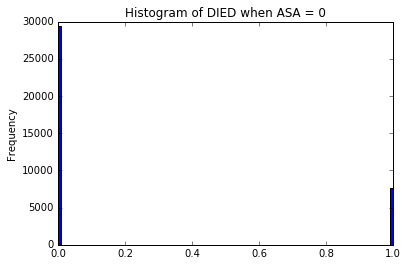

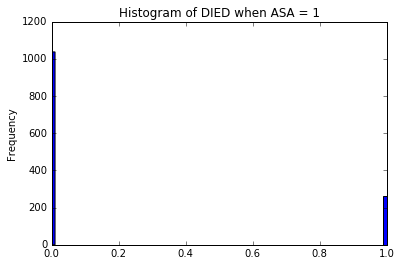

In [20]:
###ASA = 0
allStateData[allStateData.ASA == 0.].DIED.plot('hist', bins = 100)
plt.title('Histogram of DIED when ASA = 0'); plt.show()
###ASA = 1
allStateData[allStateData.ASA == 1.].DIED.plot('hist', bins = 100)
plt.title('Histogram of DIED when ASA = 1'); plt.show()

The table and plots show us that both the cases almost have the exact same distribution.

### Specific Answers

In [21]:
from scipy import stats  

#### Q1 Is there a relation between Aspirin Usage (ASA) and Hospital Stay (LOS)?

To answer this question, we run a simple Mann-Whitney (Wilcoxon Rank Sum) test on both the groups. Mann-Whitney U tests are preferred over a t-test since the data is very unbalanced and it is not normal. It is essentially a non-parametric alternative to a t-test. Also important to note here, this test is comparing the medians and not the means. Means are really only relevant if the distributions are normal, since CLT doesnt apply otherwise.

Please note here that this variable (LOS) follows a Pareto distribution (see the data exploration part). So it might make sense for us to find a test that is specifically meant for such distributions. I am searching for one and will update this as soon as I find something.

In [22]:
group1_LOS =  allStateData[allStateData.ASA == 0.].LOS
group2_LOS =  allStateData[allStateData.ASA == 1.].LOS

In [23]:
print "The median LOS of ASA = 0 is ", group1_LOS.median()

The median LOS of ASA = 0 is  9.0


In [24]:
print "The median LOS of ASA = 1 is ", group2_LOS.median()

The median LOS of ASA = 1 is  5.0


In [25]:
z_stat, p_val = stats.ranksums(group1_LOS, group2_LOS)
print "p-value: ", p_val  

p-value:  6.04562277907e-30


Since the p-value is <0.01, there is enough evidence to conclude that the mean Hospital Stay of patients that **do not** use aspirin is **greater** than those that do. However, I am **not** convinced that this is a causal relationship. It could just so happen that patients that are given aspirin are just suffering a less severe SAH and are let out sooner as a result.

#### Q2 Is there a relation between Aspirin Usage (ASA) and Mortality (DIED)?

Since the data here is boolean and independent, I suggest we use a **Chi-Squared test**.

In [26]:
group1_DIED =  allStateData[allStateData.ASA == 0.].DIED
group2_DIED =  allStateData[allStateData.ASA == 1.].DIED

In [27]:
print "The mean SCORE of ASA = 0 is ", group1_DIED.mean()

The mean SCORE of ASA = 0 is  0.205324738638


In [28]:
print "The mean SCORE of ASA = 1 is ", group2_DIED.mean()

The mean SCORE of ASA = 1 is  0.201078582435


In [29]:
ctDIED = pd.crosstab(allStateData.DIED, allStateData.ASA); ctDIED

ASA,0.0,1.0
DIED,,
0.0,29341,1037
1.0,7581,261


In [30]:
p_val = stats.chi2_contingency(ctDIED)[1]
print "p-value: ", p_val  

p-value:  0.73584159193


In [ ]:
# even the R implementation of ChiSq test, shows the same result. 
'''
prop.test(c(29341,1037),c(36922,1298),correct=FALSE)

	2-sample test for equality of proportions without
	continuity correction

data:  c(29341, 1037) out of c(36922, 1298)
X-squared = 0.13863, df = 1, p-value = 0.7096
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.02643650  0.01794419
sample estimates:
   prop 1    prop 2 
0.7946753 0.7989214 
'''

Since the p-value is >0.05, there is **not** enough evidence to prove that there is a difference in the mortality rate between patients that use aspirin and those that dont.

#### Q3 Is there a relation between Aspirin Usage (ASA) and Severity of SAH (SCORE)?

As seen in the exploration part, this variable is discrete and not really continuous. Mann-Whitney assumes that the distribution is continuous so it might **not** be appropriate here. Hence, we also test using Chi-Sq, which will show if the distributions are similar or not.

In [31]:
group1_SCORE =  allStateData[allStateData.ASA == 0.].SCORE
group2_SCORE =  allStateData[allStateData.ASA == 1.].SCORE

In [32]:
print "The median SCORE of ASA = 0 is ", group1_SCORE.median()

The median SCORE of ASA = 0 is  0.932393848896


In [33]:
print "The median SCORE of ASA = 1 is ", group2_SCORE.median()

The median SCORE of ASA = 1 is  0.932393848896


In [34]:
z_stat, p_val = stats.ranksums(group1_SCORE, group2_SCORE)#, alternative = 'greater')  
print "p-value: ", p_val  

p-value:  9.82451856083e-05


Since the p-value is <0.01, there is enough evidence to prove that the severity of SAH of patients that use aspirin is greater than those that don't use aspirin. 

In [35]:
ctSevere = pd.crosstab(allStateData.SCORE, allStateData.ASA); ctSevere

ASA,0.0,1.0
SCORE,,
0.298197,575,16
0.463013,8,2
0.774142,3,0
0.932394,21366,830
1.447735,297,27
1.558931,1,0
1.750672,4,0
2.225541,236,4
2.420563,43,3


In [36]:
p_val = stats.chi2_contingency(ctSevere)[1]
print "p-value: ", p_val

p-value:  3.35212665197e-09


This result shows that the distributions are **NOT** similar. Given that this is the case and the Mann-Whitney test is significant. We can move forward with concluding that Patients on Aspirin and those using it have varying levels of severity of SAH. This does **not** mean that using a higher dose of aspirin results in more severe SAH or vice versa. It just shows that they are related. 